In [1]:
using Distributions
using Optim
using Random
using Roots
using StaticArrays
using StatsFuns
using StatsPlots
default(fmt=:png, titlefontsize=10, size=(400, 250))

In [2]:
logisticmodel(α, β, x) = Bernoulli(logistic(α + β*x))

randlogistic(α, β, x) = @. rand(logisticmodel(α, β, x))

function negloglik(x, y, α, β)
    -sum(logpdf(logisticmodel(α, β, x), y) for (x, y) in zip(x, y))
end

function score_α(x, y, α, β)
    sum(logistic(α + β*x) - y for (x, y) in zip(x, y))
end

function score_β(x, y, α, β)
    sum(x*(logistic(α + β*x) - y) for (x, y) in zip(x, y))
end

function fisherinfo_αα(x, α, β)
    sum(exp(-(α + β*x))*logistic(α + β*x)^2 for x in x)
end

function fisherinfo_αβ(x, α, β)
    sum(x*exp(-(α + β*x))*logistic(α + β*x)^2 for x in x)
end

function fisherinfo_ββ(x, α, β)
    sum(x^2*exp(-(α + β*x))*logistic(α + β*x)^2 for x in x)
end

function fisherinfo(x, α, β)
    a = fisherinfo_αα(x, α, β)
    b = fisherinfo_αβ(x, α, β)
    c = fisherinfo_ββ(x, α, β)
    a, b, c
end

function invsym2x2(a, b, c)
    det = a*c - b^2
    c/det, -b/det, a/det
end

function invfisherinfo(x, α, β)
    invsym2x2(fisherinfo(x, α, β)...)
end

function mle(x, y; alg=LBFGS())
    f(w) = negloglik(x, y, w[1], w[2])
    o = optimize(f, MVector(0.0, 0.0), alg)
    o.minimizer
end

function sim_Z(;
        α=1, β=2, xnew=1, n=40,
        x=rand(Uniform(-3, 2), n),
        L=10^4, alg=LBFGS()
    )
    Z = zeros(0)
    alphahat = zeros(0)
    betahat = zeros(0)
    for _ in 1:L
        y = randlogistic(α, β, x)
        α̂, β̂ = mle(x, y; alg)
        push!(alphahat, α̂)
        push!(betahat, β̂)
        aa, bb, cc = invfisherinfo(x, α̂, β̂)
        sehat = √(aa*xnew^2 + 2bb*xnew + cc)
        z = ((α̂-α) + (β̂-β)*xnew)/sehat
        push!(Z, z)
    end
    Z, alphahat, betahat
end

function mle_β(x, y, β; alg=Order2())
    f(α) = score_α(x, y, α, β)
    find_zero(f, 0.0, alg)
end

function chisqstat_β(x, y, β)
    α̃ = mle_β(x, y, β)
    v = score_β(x, y, α̃, β)
    a, b, c = fisherinfo(x, α̃, β)
    cc = a/(a*c - b^2)
    v^2 * cc
end

function sim_chisqstat_β(; α=1, β=2, n=40, L=10^4)
    x = rand(Uniform(-2, 2), n)
    C = zeros(0)
    for _ in 1:L
        y = randlogistic(α, β, x)
        push!(C, chisqstat_β(x, y, β))
    end
    C
end

sim_chisqstat_β (generic function with 1 method)

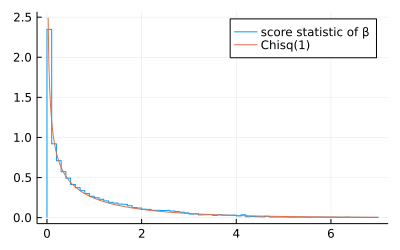

In [3]:
C = sim_chisqstat_β(α=1, β=2, n=40, L=10^5)
stephist(C; norm=true, bin=0:0.1:7, label="score statistic of β")
plot!(Chisq(1), 0.025, 7; label="Chisq(1)")

  4.658755 seconds (11.09 M allocations: 584.794 MiB, 3.87% gc time, 50.40% compilation time)


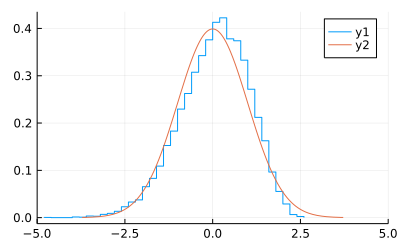

In [4]:
n = 100
α, β = 1, 2
x = rand(Uniform(-3, 2), n)
Z, α̂, β̂ = @time sim_Z(; α, β, n, x, L=10^4)
stephist(Z; norm=true, xlim=(-5, 5))
plot!(Normal())

In [5]:
mean(α̂), mean(β̂)

(1.0636991996824396, 2.126996461668511)

In [6]:
fisherinfo(x, 1, 2)

(10.891883948785146, -5.5104498474082115, 9.909509814195166)

In [7]:
invfisherinfo(x, 1, 2)

(0.12775226467685716, 0.07104008781405263, 0.14041691941831175)

In [8]:
var(α̂), cov(α̂, β̂), var(β̂)

(0.1681744529391595, 0.1091466733989751, 0.20679819280003378)

In [9]:
function pvalue(α̂, β̂, x, xnew, p)
    aa, bb, cc = invfisherinfo(x, α̂, β̂)
    sehat = √(aa*xnew^2 + 2bb*xnew + cc)
    z = (α̂ + β̂*xnew - logit(p))/sehat
    2ccdf(Normal(), abs(z))
end

pvalue (generic function with 1 method)

n = 40
(α, β) = (1, 2)
(α̂, β̂) = mle(x, y) = [1.4169848980249171, 2.5505015918656007]


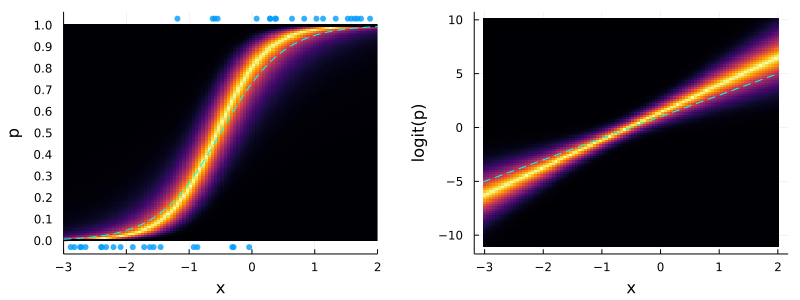

In [10]:
function plot_pvaluefunc(
        α = 1, β = 2, n = 40,
        x = rand(Uniform(-3, 2), n),
        y = randlogistic(α, β, x)
    )
    @show n
    @show α, β
    @show α̂, β̂ = mle(x, y)

    xs = range(-3, 2, 100)
    ps = range(0, 1, 100)
    pval = pvalue.(α̂, β̂, Ref(x), xs', ps)
    P = heatmap(xs, ps, pval; colorbar=false, xlim=extrema(xs))
    plot!(x -> logistic(α + β*x); label="", c=:cyan, ls=:dash)
    scatter!(x, 1.06y .- 0.03; label="", c=1, msc=:auto, alpha=0.8)
    plot!(xguide="x", yguide="p")
    plot!(ytick=0:0.1:1)
    plot!(leftmargin=4Plots.mm, bottommargin=4Plots.mm)

    logitps = range(-11, 10, 100)
    pval = pvalue.(α̂, β̂, Ref(x), xs', logistic.(logitps))
    Q = heatmap(xs, logitps, pval; colorbar=false)
    plot!(x -> α + β*x; label="", c=:cyan, ls=:dash)
    plot!(xguide="x", yguide="logit(p)")
    plot!(leftmargin=8Plots.mm, bottommargin=4Plots.mm)

    plot(P, Q; size=(800, 300))
end

Random.seed!(4649373)
plot_pvaluefunc()

n = 40
(α, β) = (1, 2)
(α̂, β̂) = mle(x, y) = [0.5891075130088409, 1.8417083781539179]


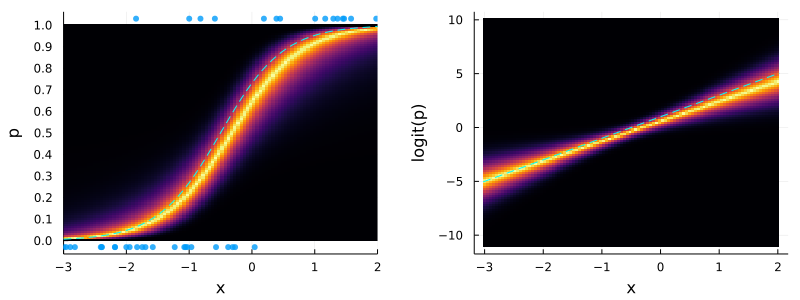

In [11]:
plot_pvaluefunc()

n = 40
(α, β) = (1, 2)
(α̂, β̂) = mle(x, y) = [1.2656779930204578, 2.264063109845312]


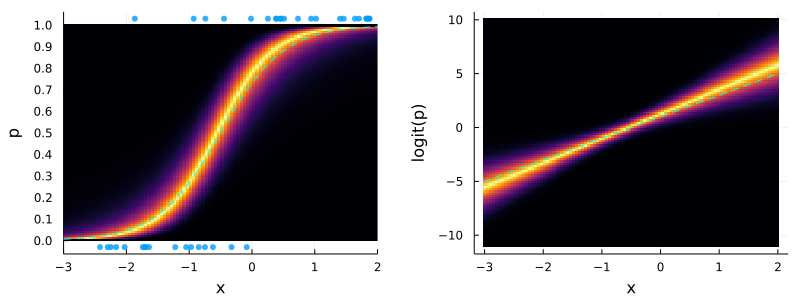

In [12]:
plot_pvaluefunc()

n = 40
(α, β) = (1, 2)
(α̂, β̂) = mle(x, y) = [1.286230618197936, 2.4470398508445794]


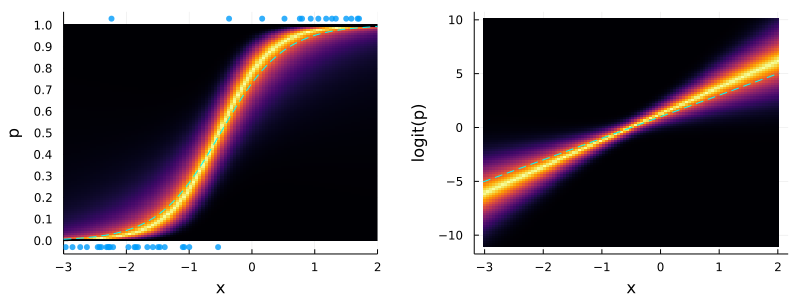

In [13]:
plot_pvaluefunc()

n = 40
(α, β) = (1, 2)
(α̂, β̂) = mle(x, y) = [1.7514872288866221, 3.206618375550499]


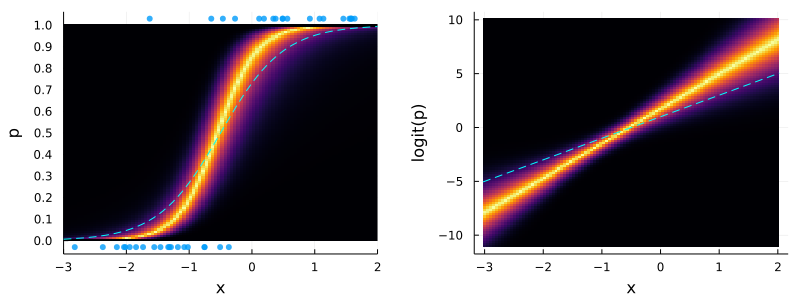

In [14]:
plot_pvaluefunc()

n = 40
(α, β) = (1, 2)
(α̂, β̂) = mle(x, y) = [1.2417884849578098, 1.8246667774058745]


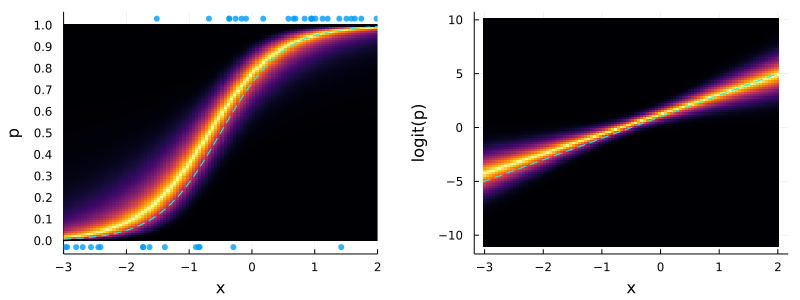

In [15]:
plot_pvaluefunc()